In [1]:
#!pip install bs4
#!pip install lxml
#!pip install tqdm

In [115]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import lxml, requests, re, time, csv, random
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
mpl.rcParams['axes.unicode_minus']
import matplotlib.pyplot as plt
print('libraries imported')

libraries imported


In [2]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import lxml, requests, re, time, csv, random
from tqdm import tqdm
print('libraries imported')

fake_headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.79 Safari/537.36'
}
csv_file=open('doubanTop250.csv','w',newline='',encoding="utf-8-sig")
csv_writer=csv.writer(csv_file)
csv_writer.writerow(['movie_title','year','douban_rating','imdb_rating','douban_url','imdb_url','director','writer','star','genre','country','language','premier','runtime','alt_title'])

#loop through pages
for n in range(0,250,25):
    url = f"https://movie.douban.com/top250?start={n}&filter=" 
    res= requests.get(url, headers=fake_headers) #add the fake header.
    soup = BeautifulSoup(res.text, 'lxml')
    movies=soup.find_all('div',class_='info')
    print('Page '+str(n)+' loaded')
    
    #loop through the movielist get movie_title,year,douban_rating,imdb_rating,douban_url,imdb_url,movieinfo
    for movie in tqdm(movies):
        #movie_title
        movie_title=movie.a.span.text
        
        #douban_url
        douban_url=movie.a['href']
        res_db= requests.get(douban_url, headers=fake_headers)
        soup_db = BeautifulSoup(res_db.text, 'lxml')
        
        #year the movie made
        year=soup_db.find('span',class_='year').text[1:5]
        
        #douban_rating
        douban_rating=soup_db.select('#interest_sectl > div.rating_wrap.clearbox > div.rating_self.clearfix > strong')[0].text
        
        #list of info (movieinfo)
        info=soup_db.find('div',id='info').text
        movieinfo=info.split('\n')[1:-2]
        if '官方网站' in info:
            movieinfo.pop(4)
        elif '官方小站' in info:
            del movieinfo[-2:]
        movieinfo=[i[4:] for i in movieinfo]
        movieinfo[4]=movieinfo[4][5:]
        movieinfo[6]=movieinfo[6][2:]
        
        #imdb_url
        imdbregex=re.compile(r'IMDb链接: (.*)')
        mo=imdbregex.search(info)
        imdb_id=mo.group(1)
        imdb_url='https://www.imdb.com/title/'+imdb_id
        
        #request imdb page
        res_im= requests.get(imdb_url)
        soup_im = BeautifulSoup(res_im.text, 'lxml')
        
        #imdb_rating
        imdb_rating=soup_im.select('#title-overview-widget > div.vital > div.title_block > div > \
        div.ratings_wrapper > div.imdbRating > div.ratingValue > strong > span')[0].text.strip()
        
        #writerow to 
        csv_writer.writerow([movie_title,year,douban_rating,imdb_rating,douban_url,imdb_url]+movieinfo)
        time.sleep(random.randint(1,5))

csv_file.close()
print('All finished')

In [30]:
#load into pandas
pd.set_option('display.max_colwidth', 0)
df=pd.read_csv('doubanTop250.csv',error_bad_lines=False)
print(df.columns)
print(df.shape[0])

Index(['movie_title', 'year', 'douban_rating', 'imdb_rating', 'douban_url',
       'imdb_url', 'director', 'writer', 'star', 'genre', 'country',
       'language', 'premier', 'runtime', 'alt_title'],
      dtype='object')
250


In [93]:
#build a new data frame with the information we need.
df_ratings=df[['movie_title', 'year', 'douban_rating', 'imdb_rating','genre', 'country']]
df_ratings.head()

,movie_title,year,douban_rating,imdb_rating,genre,country
0,肖申克的救赎,1994,9.7,9.3,剧情 / 犯罪,美国
1,霸王别姬,1993,9.6,8.1,剧情 / 爱情 / 同性,中国大陆 / 中国香港
2,阿甘正传,1994,9.5,8.8,剧情 / 爱情,美国
3,这个杀手不太冷,1994,9.4,8.5,剧情 / 动作 / 犯罪,法国
4,美丽人生,1997,9.5,8.6,剧情 / 喜剧 / 爱情 / 战争,意大利


In [ ]:
# add the rating difference calculation between douban ratings and imdb ratings
df_ratings['rating_difference']=df_ratings.douban_rating-df_ratings.imdb_rating

In [46]:
df_ratings.sort_values(['rating_difference'],ascending=False).head(10)

,movie_title,year,douban_rating,imdb_rating,genre,country,rating_difference
153,纵横四海,1991,8.8,6.8,剧情 / 喜剧 / 动作 / 犯罪,中国香港,2.0
172,黑客帝国3：矩阵革命,2003,8.7,6.8,动作 / 科幻,美国 / 澳大利亚,1.9
143,天书奇谭,1983,9.2,7.4,动画 / 奇幻,中国大陆,1.8
75,海蒂和爷爷,2015,9.2,7.4,剧情 / 家庭 / 冒险,德国 / 瑞士 / 南非,1.8
130,恐怖直播,2013,8.8,7.1,剧情 / 悬疑 / 犯罪,韩国,1.7
177,你看起来好像很好吃,2010,8.9,7.3,剧情 / 动画 / 儿童,日本,1.6
5,泰坦尼克号,1997,9.4,7.8,剧情 / 爱情 / 灾难,美国,1.6
239,我爱你,2011,9.0,7.4,剧情 / 爱情,韩国,1.6
188,恐怖游轮,2009,8.5,6.9,剧情 / 悬疑 / 惊悚,英国 / 澳大利亚,1.6
66,让子弹飞,2010,8.8,7.3,剧情 / 喜剧 / 动作 / 西部,中国大陆 / 中国香港,1.5


-**'once a thief' from John Woo has higher douban rating (8.8) compared to imdb (6.8), ranked number 1,**

**followed by 'Matrix 3' (8.7 vs 6.8).**

**Douban is a more community based website,
looks like Chinese regular audience really enjoy action movies.**

In [24]:
df_ratings.sort_values(['rating_difference'],ascending=True).head(30)

,movie_title,year,douban_rating,imdb_rating,genre,country,rating_difference
77,低俗小说,1994,8.8,8.9,剧情 / 喜剧 / 犯罪,美国,-0.1
166,你的名字。,2016,8.4,8.4,剧情 / 爱情 / 动画,日本,0.0
21,教父,1972,9.3,9.2,剧情 / 犯罪,美国,0.1
25,蝙蝠侠：黑暗骑士,2008,9.2,9.0,剧情 / 动作 / 科幻 / 惊悚 / 犯罪,美国 / 英国,0.2
47,搏击俱乐部,1999,9.0,8.8,剧情 / 动作 / 悬疑 / 惊悚,美国 / 德国,0.2
158,萤火虫之墓,1988,8.7,8.5,剧情 / 动画 / 战争,日本,0.2
50,教父2,1974,9.2,9.0,剧情 / 犯罪,美国,0.2
164,记忆碎片,2000,8.6,8.4,剧情 / 悬疑 / 惊悚 / 犯罪,美国,0.2
198,终结者2：审判日,1991,8.7,8.5,动作 / 科幻,美国 / 法国,0.2
242,发条橙,1971,8.5,8.3,剧情 / 科幻 / 犯罪,英国 / 美国,0.2


In [40]:
#check how many of the 250 received higher rating on douban then imdb. 
df_ratings[df_ratings['rating_difference']> 0].shape[0]

(248, 7)

**looks like 248 movies out of 250 have higher rating in douban,**

**'pulp fiction' is the only movie receives lower rating in douban.**

In [44]:
#check which country makes most movies in the top 250 list
df_ratings.groupby(['country']).size().sort_values(ascending=False).head(10)

country
美国             77
日本             31
中国香港           13
韩国             10
美国 / 英国        10
英国 / 美国        8 
中国大陆           7 
中国大陆 / 中国香港    7 
美国 / 德国        6 
美国 / 法国        5 
dtype: int64

**US makes most movies that received high rating, 77 not counting the movies co-produced with other countries, only 14 movies coming from mainland China.**

In [41]:
# a few chinese language movies received high ratings in imdb.
df_ratings[df_ratings.country.str.contains('中国')].sort_values(by=['imdb_rating'],ascending=False).head(10)

,movie_title,year,douban_rating,imdb_rating,genre,country,rating_difference
206,牯岭街少年杀人事件,1991,8.8,8.4,剧情 / 犯罪,中国台湾,0.4
27,活着,1994,9.2,8.3,剧情 / 家庭 / 历史,中国大陆 / 中国香港,0.9
37,鬼子来了,2000,9.2,8.2,剧情 / 历史 / 战争,中国大陆,1.0
100,阳光灿烂的日子,1994,8.8,8.2,剧情 / 爱情,中国大陆 / 中国香港,0.6
1,霸王别姬,1993,9.6,8.1,剧情 / 爱情 / 同性,中国大陆 / 中国香港,1.5
122,甜蜜蜜,1996,8.8,8.1,剧情 / 爱情,中国香港,0.7
112,一一,2000,9.0,8.1,剧情 / 爱情 / 家庭,中国台湾 / 日本,0.9
102,重庆森林,1994,8.7,8.1,剧情 / 爱情,中国香港,0.6
168,花样年华,2000,8.6,8.1,剧情 / 爱情,中国香港,0.5
54,大闹天宫,1961,9.3,8.1,动画 / 奇幻,中国大陆,1.2


**Douban's favoriate 'Farewell My Concubine' by chen kaige (ranked number 2 on douban) also received high rating on imdb.**

In [ ]:
#now let's dig into the details to find which genre is the Chinese audience's favourite.
df_ratings.genre = df_ratings['genre'].str.split(' / ')

In [96]:
df_genre = df_ratings[['movie_title','year','genre']]
df_genre.head()

,movie_title,year,genre
0,肖申克的救赎,1994,"[剧情, 犯罪]"
1,霸王别姬,1993,"[剧情, 爱情, 同性]"
2,阿甘正传,1994,"[剧情, 爱情]"
3,这个杀手不太冷,1994,"[剧情, 动作, 犯罪]"
4,美丽人生,1997,"[剧情, 喜剧, 爱情, 战争]"


In [ ]:
for index, row in df_genre.iterrows():
    for genre in row['genre']:
        df_genre.at[index, genre] = 1

df_genre.head()

In [98]:
df_genre=df_genre.fillna(0)

In [99]:
#keep only the genre in the dataframe
df_genre=df_genre.iloc[:,3:]
df_genre.head()

,剧情,犯罪,爱情,同性,动作,喜剧,战争,灾难,动画,奇幻,...,古装,家庭,传记,惊悚,运动,西部,情色,儿童,武侠,恐怖
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:
genre_ranking=df_genre.sum()
genre_ranking.sort_values(ascending=False).head(10)

剧情    186.0
爱情    55.0 
喜剧    52.0 
犯罪    47.0 
冒险    45.0 
奇幻    40.0 
惊悚    36.0 
动作    34.0 
动画    34.0 
悬疑    30.0 
dtype: float64

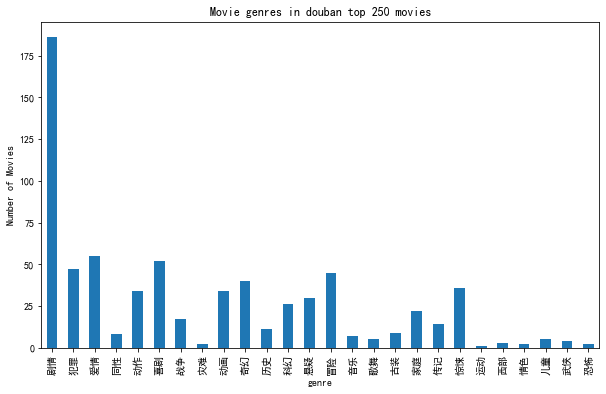

In [116]:
genre_ranking.plot(kind='bar', figsize=(10, 6))
plt.xlabel('genre') # add to x-label to the plot
plt.ylabel('Number of Movies') # add y-label to the plot
plt.title('Movie genres in douban top 250 movies') # add title to the plot

plt.show()

**186 movies has belongs to the genre 'drama', followd by 'romance','comedy','crime' and 'advanture'.**